In [22]:
import io
import sys
import pandas as pd
import numpy as np
from Pipeline import DPA
import time
import os
sys.path.append('../')
from simulate_frbs import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## DPA on dynamic spectra

In [40]:
directories = [
    "simulated_simple_broad_bursts_v4",
    "simulated_simple_narrow_bursts_v4",
    "simulated_scattered_bursts_v4",
    "simulated_complex_bursts_v4",
    "simulated_drifting_bursts_v4"
]

data = []

for directory in directories:
    data_dir = f"/Users/dirkkuiper/Documents/MacBookProDocuments/University/Thesis/Rep_Learn_FRB/{directory}"
    data_per_directory = []

    for filename in os.listdir(data_dir):
        if filename.endswith(".npy"):
            data_per_directory.append(normalize((np.load(os.path.join(data_dir, filename)))))

    data_per_directory = np.array(data_per_directory).reshape(-1, 1024 * 512)[:100]
    data.append(data_per_directory)

# Combine the data from all directories into one array
combined_data = np.concatenate(data, axis=0)

# Reshape the combined data for DPA
combined_data_2d = combined_data.reshape(-1, 1024 * 512)

In [41]:
est = DPA.DensityPeakAdvanced(Z=0.5)

In [42]:
est.fit(combined_data_2d)

DensityPeakAdvanced(Z=0.5)

In [43]:
est.topography_

[[0, 1, 27.542625404485023, 0.5433581647846062],
 [0, 2, 24.726865591432045, 0.6831300510639732],
 [0, 3, 18.717109466471854, 1.5275252316519468],
 [1, 2, 0.0, 0.0],
 [1, 3, 18.664290929838444, 0.5883484054145521],
 [2, 3, 0.0, 0.0]]

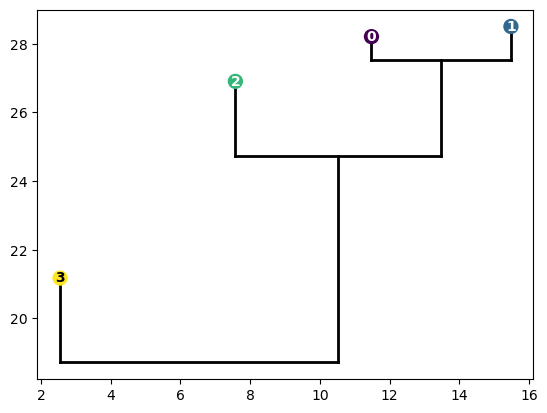

In [44]:
est.get_dendrogram()

In [54]:
est.labels_

array([3, 0, 3, 1, 1, 1, 1, 3, 3, 1, 1, 1, 3, 3, 1, 1, 1, 1, 3, 3, 3, 1,
       3, 3, 3, 1, 3, 1, 0, 1, 3, 3, 1, 1, 3, 1, 1, 0, 3, 1, 0, 3, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 1, 0, 3, 1, 3, 0, 1, 0, 0,
       0, 3, 3, 3, 1, 3, 3, 1, 1, 0, 3, 1, 3, 1, 3, 1, 1, 1, 1, 3, 1, 3,
       3, 1, 1, 3, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 3, 1, 1, 0, 1,
       1, 3, 0, 0, 3, 1, 3, 0, 1, 1, 3, 0, 1, 3, 3, 1, 1, 1, 1, 0, 0, 3,
       0, 0, 1, 1, 3, 0, 1, 0, 0, 1, 3, 1, 0, 0, 0, 3, 1, 0, 1, 3, 0, 3,
       1, 1, 3, 3, 0, 3, 3, 1, 1, 1, 0, 1, 1, 1, 0, 3, 0, 3, 1, 1, 3, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 3, 0, 0, 3, 1, 3, 1, 3, 0, 3, 0, 1, 1,
       0, 3, 0, 2, 0, 3, 0, 2, 2, 3, 3, 3, 3, 0, 3, 0, 0, 0, 0, 3, 3, 0,
       3, 0, 0, 3, 3, 3, 0, 0, 2, 0, 3, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 3, 3, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 3, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 2, 0, 3, 2, 0, 3, 2, 2, 2, 3, 0, 0, 1, 0, 0, 3, 0,
       0, 0, 0, 0, 3, 3, 3, 0, 3, 0, 2, 0, 0, 3, 1,

In [56]:
from collections import Counter

cluster_labels = est.labels_

# Assuming you have a mapping of cluster labels to FRB types
# Replace this with your actual mapping
frb_types_mapping = {
    0: "narrow",
    1: "broad",
    2: "scattered",
    3: "complex",
    4: "drifting"
}

# Combine the cluster labels and FRB types into a list of tuples
combined_info = list(zip(cluster_labels, [frb_types_mapping[i % len(frb_types_mapping)] for i in range(len(cluster_labels))]))

# Count the occurrences of each FRB type within each cluster
cluster_frb_counts = {cluster: Counter(frb_type for cluster_label, frb_type in combined_info if cluster_label == cluster)
                      for cluster in set(cluster_labels)}

# Print the results
for cluster, frb_counts in cluster_frb_counts.items():
    print(f"Cluster {cluster}: {', '.join(f'{count} {frb_type}' for frb_type, count in frb_counts.items())}")


Cluster 0: 30 broad, 40 complex, 32 scattered, 32 narrow, 28 drifting
Cluster 1: 28 complex, 28 drifting, 30 narrow, 28 broad, 31 scattered
Cluster 2: 5 broad, 4 narrow, 1 complex, 5 scattered, 2 drifting
Cluster 3: 34 narrow, 32 scattered, 31 complex, 42 drifting, 37 broad


## DPA on lightcurves

In [33]:
directories = [
    "simulated_simple_broad_bursts_v4",
    "simulated_simple_narrow_bursts_v4",
    "simulated_scattered_bursts_v4",
    "simulated_complex_bursts_v4",
    "simulated_drifting_bursts_v4"
]

data = []

for directory in directories:
    data_dir = f"/Users/dirkkuiper/Documents/MacBookProDocuments/University/Thesis/Rep_Learn_FRB/{directory}"
    data_per_directory = []

    for filename in os.listdir(data_dir):
        if filename.endswith(".npy"):
            dynamic_spectra = (np.load(os.path.join(data_dir, filename)))
            data_per_directory.append(normalize(np.sum(dynamic_spectra, axis=1)))

    data_per_directory = np.array(data_per_directory).reshape(-1, 1024)[:100]
    print(np.max(data_per_directory))
    data.append(data_per_directory)

# Combine the data from all directories into one array
combined_data = np.concatenate(data, axis=0)

# Reshape the combined data for PCA
combined_data_2d = combined_data.reshape(-1, 1024)

print(combined_data_2d.shape)

1.0
1.0
1.0
1.0
1.0
(500, 1024)


In [37]:
est = DPA.DensityPeakAdvanced(Z=0.5)
est.fit(combined_data_2d)

DensityPeakAdvanced(Z=0.5)

In [38]:
est.topography_

[[0, 1, 7.142156917907826, 0.30318178032195786],
 [0, 2, 9.024764229168056, 0.2901442287369986],
 [1, 2, 0.0, 0.0]]

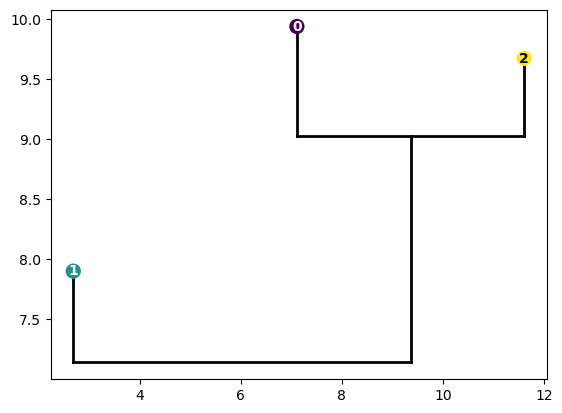

In [39]:
est.get_dendrogram()